<a href="https://colab.research.google.com/github/yoouza/makeup_with_GAN/blob/master/Align_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dlib
import matplotlib.patches as patches
import tensorflow as tf
import cv2
import gc

# Align Face + 전처리
크롤링 파일 한 군데에 몰아넣기
- [크롤링]화장 전후
- [크롤링]화장 전
- [크롤링]화장 후

In [ ]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('/content/drive/My Drive/머신러닝 1조 /shape_predictor_5_face_landmarks.dat')

def align_faces(img):
    dets = detector(img, 1)
    objs = dlib.full_object_detections()
    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
    faces = dlib.get_face_chips(img, objs, size=150, padding=0.35) # original size=256
    return faces

def add_blank(image):
    height = image.shape[0]
    width = image.shape[1]
    square = np.zeros((max(height, width), max(height, width), 3))
    if height > width:
        square[:, (height-width)//2:(height-width)//2 + width, :] = image
    else:
        square[(width-height)//2:(width-height)//2 + height, :, :] = image
    return square

path_dir = ['/content/drive/My Drive/머신러닝 1조 /[크롤링]화장 전후',
            '/content/drive/My Drive/머신러닝 1조 /[크롤링]화장 전',
            '/content/drive/My Drive/머신러닝 1조 /[크롤링]화장 후']
file_before_after = os.listdir(path_dir[0])
file_before = os.listdir(path_dir[1])
file_after = os.listdir(path_dir[2])

before = np.zeros((len(file_before_after + file_before), 150, 150, 3))
after = np.zeros((len(file_before_after + file_after), 150, 150, 3))

# 1. 화장 전 후 사진 쪼개기
for i, file in enumerate(file_before_after):
    img = dlib.load_rgb_image(path_dir[0]+ '/' + file)
    n_half = img.shape[1] // 2
    bef = img[:,:n_half,:]
    aft = img[:,n_half:,:]
    try:
        before[i,:] = align_faces(bef)[0]
    except RuntimeError: # 얼굴 인식 안되는 경우 align 과정 거치지 않고 기본 전처리만 진행
        bef = add_blank(bef)
        bef = cv2.resize(bef, (150, 150))
        before[i,:] = bef
    try:
        after[i,:] = align_faces(aft)[0]
    except RuntimeError:
        aft = add_blank(aft)
        aft = cv2.resize(aft, (150, 150))
        after[i,:] = aft

# 2. 화장 전 단독 사진 before에 이어서 추가
for i, file in enumerate(file_before):
    img = dlib.load_rgb_image(path_dir[1]+ '/' + file)
    try:
        before[i + len(file_before_after),:] = align_faces(img)[0]
    except RuntimeError:
        img = add_blank(img)
        img = cv2.resize(img, (150, 150))
        before[i + len(file_before_after),:] = img

# 3. 화장 후 단독 사진 after에 이어서 추가
for i, file in enumerate(file_after):
    img = dlib.load_rgb_image(path_dir[2] + '/' + file)
    try:
        after[i + len(file_before_after),:] = align_faces(img)[0]
    except RuntimeError:
        img = add_blank(img)
        img = cv2.resize(img, (150, 150))
        after[i + len(file_before_after),:] = img

before, after = before.astype(np.uint8), after.astype(np.uint8)

In [ ]:
before.shape, after.shape

((74, 150, 150, 3), (76, 150, 150, 3))

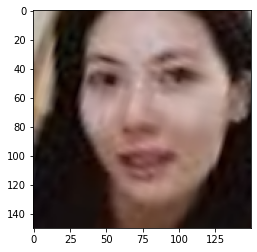

In [ ]:
plt.imshow(before[-1,:])

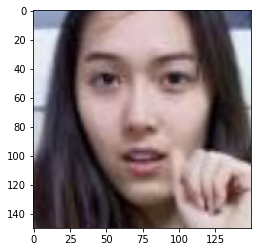

In [ ]:
plt.imshow(after[-1,:])

In [ ]:
# 화장 전 후 쪼갠 사진 시각화
def makeup_before_after(number):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(before[number,:])
    ax[0].set_title('before')
    ax[1].imshow(after[number,:])
    ax[1].set_title('after')

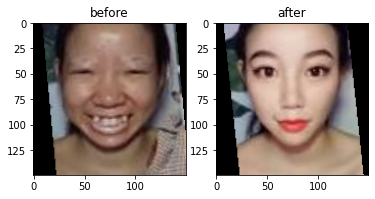

In [ ]:
makeup_before_after(0) # 얼굴 인식 잘 된 경우

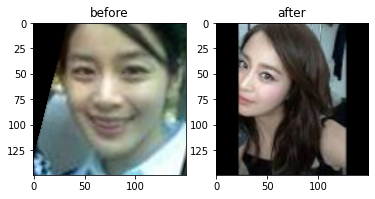

In [ ]:
makeup_before_after(5) # 얼굴 인식 after가 안 된 경우

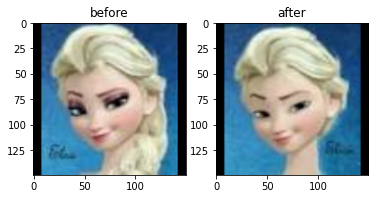

In [ ]:
makeup_before_after(34) # 얼굴 인식 둘 다 안 된 경우(얘는 심지어 순서도 바꼈네유,,)

# Align Face 시각화(참고용)

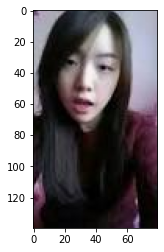

In [ ]:
img = dlib.load_rgb_image('/content/drive/My Drive/머신러닝 1조 /[크롤링]화장 전후/11.jpg')
n_half = img.shape[1] // 2
before = img[:,:n_half,:]
after = img[:,n_half:,:]
plt.imshow(before)

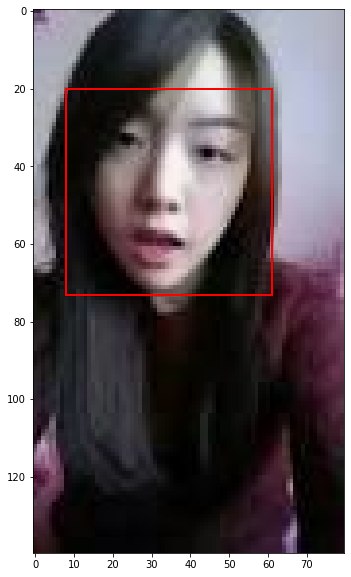

In [ ]:
img_result = before.copy()
dets = detector(before, 1)

if len(dets) == 0:
    print('cannot find faces!')
fig, ax = plt.subplots(1, figsize=(16, 10))
for det in dets:
    x, y, w, h = det.left(), det.top(), det.width(), det.height()

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img_result)

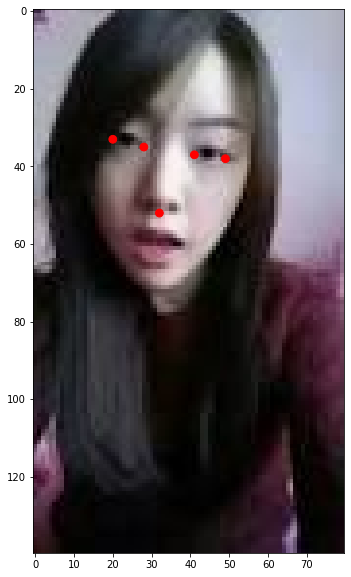

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections()

for detection in dets:
    s = sp(img, detection)
    objs.append(s)
    
    for point in s.parts():
        circle = patches.Circle((point.x, point.y), radius=1, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

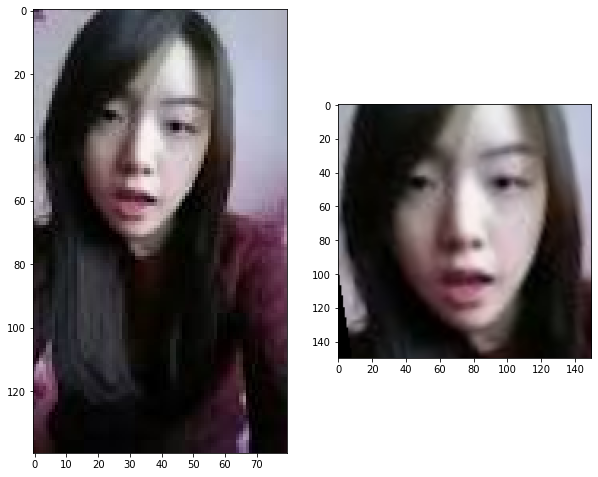

In [ ]:
faces = dlib.get_face_chips(img, objs, size=150, padding=0.3)
fig, axes = plt.subplots(1, len(faces)+1, figsize=(10, 10))
axes[0].imshow(before)
for i, face in enumerate(faces):
    axes[i+1].imshow(face)

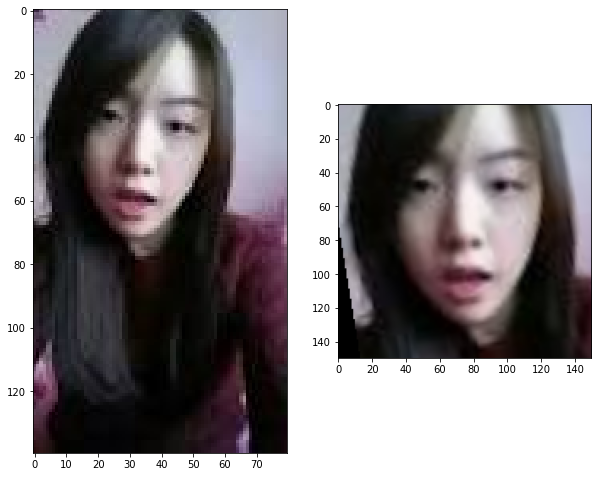

In [ ]:
def align_faces(img):
    dets = detector(img, 1)
    objs = dlib.full_object_detections()
    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
    faces = dlib.get_face_chips(img, objs, size=150, padding=0.35) # size=256
    return faces

test_img = before
test_faces = align_faces(test_img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(10, 10))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

In [ ]:
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.

def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)

In [ ]:
# src_img = img1_faces[0]
# ref_img = img2_faces[0]

# X_img = preprocess(src_img)
# X_img = np.expand_dims(X_img, axis=0)

# Y_img = preprocess(ref_img)
# Y_img = np.expand_dims(Y_img, axis=0)

# output = sess.run(Xs, feed_dict={
#     X: X_img,
#     Y: Y_img
# })

# output_img = postprocess(output[0])

# fig, axes = plt.subplots(1, 3, figsize=(20, 10))
# axes[0].set_title('Source')
# axes[0].imshow(src_img)
# axes[1].set_title('Reference')
# axes[1].imshow(ref_img)
# axes[2].set_title('Result')
# axes[2].imshow(output_img)